<a href="https://colab.research.google.com/github/arangodb/interactive_tutorials/blob/master/notebooks/Graph_Retail_Descriptive_Analytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
!git clone -b retail_data_branch --single-branch https://github.com/arangodb/interactive_tutorials.git
!rsync -av  interactive_tutorials/notebooks/data  rsync -av interactive_tutorials/notebooks/tools interactive_tutorials/notebooks/img ./ --exclude=.git
!pip install python-arango
!pip install arangopipe==0.0.70.0.0
!pip install pandas PyYAML==5.1.1 sklearn2
!pip install jsonpickle
!pip3 install networkx
!pip3 install matplotlib
!pip3 install adbnx-adapter==0.0.0.2.5.3.post1
!pip install seaborn
!pip install node2vec
!pip install hdbscan
!pip install pyclustertend
!chmod a+x tools/* 

# Overview
In the previous notebook, characteristic features of the frequent shopper group were identified using ideas used to characterize bi-partite graphs and networks in general. In particular, we can identify the customer and the item projection graphs as _small world networks_. _Small world networks_ have higher clustering coefficients than _Erdos Renyi_ random graphs. 
In _small world networks_ , (Watts-Strogatz):
* Most nodes have similar degrees. 
* A small set of nodes have high degrees.
* A small set of nodes have low degrees. 
* Such a distribution of degrees has a familiar bell-shaped structure.

These are the characteristics that we observed when the degree distributions of the graphs were plotted. Small-world networks have _cliques_, which were also observed and identified in the previous notebook. 

Unlike _scale free_ networks, _small world_ networks do not have _hubs_; _Hubs_ refer to nodes with very high degrees. As a very high degree would imply, _hub_ nodes are attached to many other nodes. In a small-world network, most nodes have a similar range of degrees. In contrast, in _scale free_, networks have a small set of nodes with very high degrees, with most nodes having low degrees. Such a structure, when plotted, shows a lot of clustering around the hubs.

We can use_Graph embedding_ methods to determine a _Euclidean_ representation of graph nodes. This representation permits us to apply a body of machine learning methods to perform machine learning and data analysis tasks. For example, we can use a visualization technique, such as the _t Stochastic Neighborhood Embedding (tSNE)_ to visualize the nodes in the graph. When visualized, we will note that most nodes are _close_, in a distance sense of the word, to a similar number of nodes such as in a _small world_ network. 

This notebook will show that the _frequent shopper network_ has the characteristics associated with a _small world_ network. Applications or tasks, such as diffusion of information through the network, depend on the network _type_ (small world, scale-free, etc.). Therefore, characterizing the network and identifying its type can be very important for tasks that we want to perform on it. For example, in this case, we may be interested in how best we can get customers to purchase products they have not purchased before. Companies have finite budgets for advertisement and marketing. The type of network topology influences the most effective strategy for a task (see [this paper](http://citeseerx.ist.psu.edu/viewdoc/summary?doi=10.1.1.92.6410), for example). We will also illustrate that _cliques_ are pervasive in the _frequent shopper_ group by visualizing the adjacency matrix associated with customer and item purchase graphs. As mentioned earlier, in a _small world_ network, most nodes have similar degrees. The nodes with very high and very low degrees are therefore unusual. We will use an anomaly detection method to identify these nodes.

## Load Data from Previous Analysis

In [2]:
from arangopipe.arangopipe_storage.arangopipe_api import ArangoPipe
from arangopipe.arangopipe_storage.arangopipe_admin_api import ArangoPipeAdmin
from arangopipe.arangopipe_storage.arangopipe_config import ArangoPipeConfig
from arangopipe.arangopipe_storage.managed_service_conn_parameters import ManagedServiceConnParam
mdb_config = ArangoPipeConfig()
msc = ManagedServiceConnParam()
conn_params = { msc.DB_SERVICE_HOST : "arangoml.arangodb.cloud", \
                        msc.DB_SERVICE_END_POINT : "createDB",\
                        msc.DB_SERVICE_NAME : "createDB",\
                        msc.DB_SERVICE_PORT : 8529,\
                        msc.DB_CONN_PROTOCOL : 'https',\
                        msc.DB_REPLICATION_FACTOR: 3}
        
mdb_config = mdb_config.create_connection_config(conn_params)
admin = ArangoPipeAdmin(reuse_connection = False, config = mdb_config)
ap_config = admin.get_config()
ap = ArangoPipe(config = ap_config)
proj_info = {"name": "Retail_Graph_Analytics"}
proj_reg = admin.register_project(proj_info)
mdb_config.get_cfg()

API endpoint: https://arangoml.arangodb.cloud:8529/_db/_system/createDB/createDB


/usr/local/lib/python3.7/dist-packages/urllib3/connectionpool.py:1020: InsecureRequestWarning: Unverified HTTPS request is being made to host 'arangoml.arangodb.cloud'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,


Host Connection: https://arangoml.arangodb.cloud:8529


{'arangodb': {'DB_end_point': 'createDB',
  'DB_service_host': 'arangoml.arangodb.cloud',
  'DB_service_name': 'createDB',
  'DB_service_port': 8529,
  'arangodb_replication_factor': 3,
  'conn_protocol': 'https',
  'dbName': 'MLqjv1c8ww41iw00aoqn7w4d',
  'password': 'MLmnbt5r8g3zhjh1xf3g0hg',
  'username': 'MLsg730i2uijotx66uf4pd'},
 'mlgraph': {'graphname': 'enterprise_ml_graph'}}

In [3]:
conn = mdb_config.get_cfg()
login = conn['arangodb']

In [4]:
login

{'DB_end_point': 'createDB',
 'DB_service_host': 'arangoml.arangodb.cloud',
 'DB_service_name': 'createDB',
 'DB_service_port': 8529,
 'arangodb_replication_factor': 3,
 'conn_protocol': 'https',
 'dbName': 'MLqjv1c8ww41iw00aoqn7w4d',
 'password': 'MLmnbt5r8g3zhjh1xf3g0hg',
 'username': 'MLsg730i2uijotx66uf4pd'}

In [5]:
!chmod -R 755 ./tools/*

In [6]:
# Restore an ArangoDB dump into the database.
!./tools/arangorestore  -c none --server.endpoint  http+ssl://{login["DB_service_host"]}:{login["DB_service_port"]} --server.username {login["username"]} \
--server.database {login["dbName"]} \
--server.password {login["password"]} \
--replication-factor 3  \
--input-directory "data/retail_freq_cust_data_dump_eonb3"

2021-07-23T06:38:18Z [306] INFO [05c30] {restore} Connected to ArangoDB 'http+ssl://arangoml.arangodb.cloud:8529'
2021-07-23T06:38:20Z [306] INFO [abeb4] {restore} Database name in source dump is 'MLnwgtri2tuneobbqf0hw4b'
2021-07-23T06:38:20Z [306] INFO [9b414] {restore} # Re-creating document collection 'Customers'...
2021-07-23T06:38:21Z [306] INFO [9b414] {restore} # Re-creating document collection 'datasets'...
2021-07-23T06:38:22Z [306] INFO [9b414] {restore} # Re-creating document collection 'deployment'...
2021-07-23T06:38:24Z [306] INFO [9b414] {restore} # Re-creating document collection 'devperf'...
2021-07-23T06:38:25Z [306] INFO [9b414] {restore} # Re-creating document collection 'featuresets'...
2021-07-23T06:38:27Z [306] INFO [9b414] {restore} # Re-creating document collection 'Items'...
2021-07-23T06:38:28Z [306] INFO [9b414] {restore} # Re-creating document collection 'modelparams'...
2021-07-23T06:38:30Z [306] INFO [9b414] {restore} # Re-creating document collection 'mo

## Using Embeddings to Visualize Graphs
Graph embeddings map graphs to Euclidean space (see [this post](https://github.com/rajivsam/interactive_tutorials/blob/master/notebooks/Graph_Embeddings.ipynb) for more details. There are multiple ways to generate embeddings for a graph. In this post, we will use Node2Vec to generate embeddings for a graph. As discussed in the overview, we can then visualize the graph using a technique such as tSNE. These visualizations reveal that the _frequent shoppers_ group has properties consistent with _small world_ networks. The details of generating the embeddings for the customer and item graphs are shown below.

## Create the Customer Projected Graph in Networkx

In [7]:
import networkx as nx
import pandas as pd
fp = "data/customer_projected_graph.csv"
df = pd.read_csv(fp)

In [8]:
cpg = nx.from_pandas_edgelist(df)

In [9]:
cpg.number_of_nodes()

437

## Generate the Embedding for the Customer Projection Graph with Node2Vec

In [10]:
from node2vec import Node2Vec
node2vec = Node2Vec(cpg, dimensions=32, walk_length=10, num_walks=100, workers=4)

In [11]:
model = node2vec.fit(window=10, min_count=1, batch_words=4)

In [12]:
customer_emb = { n: list(model.wv.get_vector(n)) for n in cpg.nodes()}

## Visualize the Customer Projection Graph with tSNE

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


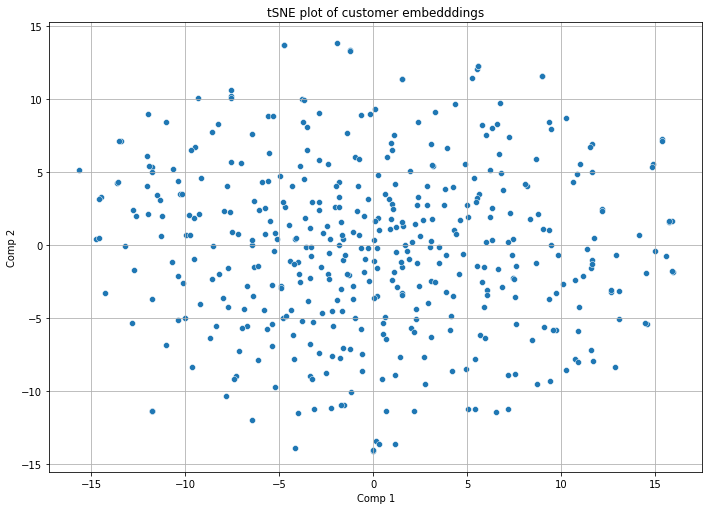

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib  import cm
from sklearn.manifold import TSNE
import seaborn as sns
fig = plt.figure(figsize=(11.7,8.27))
plt.grid(True)
plt.xlabel("Comp 1")
plt.ylabel("Comp 2")
plt.title("tSNE plot of customer embedddings")
cust_embedded = TSNE(n_components=2).fit_transform(list(customer_emb.values()))
sns.scatterplot(cust_embedded[:,0], cust_embedded[:,1])

## Load the Item Projected Graph

In [14]:
fp = "data/item_projected_graph.csv"
df = pd.read_csv(fp)

In [15]:
ipg = nx.from_pandas_edgelist(df)

In [16]:
ipg.number_of_nodes()

75

## Generate the Embedding for the Item Projection Graph with Node2Vec

In [17]:
node2vec = Node2Vec(ipg, dimensions=32, walk_length=10, num_walks=100, workers=4)

In [18]:
model = node2vec.fit(window=10, min_count=1, batch_words=4)

In [19]:
item_embedding = { n: list(model.wv.get_vector(n)) for n in ipg.nodes()}

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


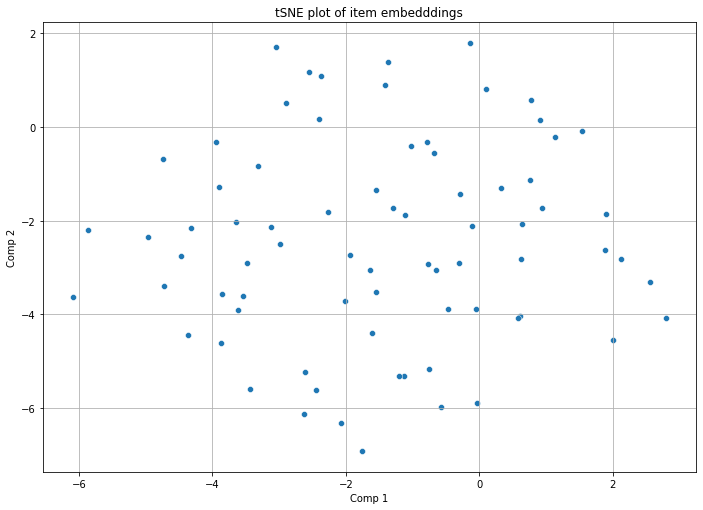

In [20]:
fig = plt.figure(figsize=(11.7,8.27))
plt.grid(True)
plt.xlabel("Comp 1")
plt.ylabel("Comp 2")
plt.title("tSNE plot of item embedddings")
item_embedded = TSNE(n_components=2).fit_transform(list(item_embedding.values()))
sns.scatterplot(item_embedded[:,0], item_embedded[:,1])

## Visualize the Adjacency Matrices
Visualizing the adjacency matrix of the customer and item projection graphs provides an additional perspective of the _frequent shoppers_ group. This is the graph perspective. The code to visualize the adjacency matrix is from [this blog](http://sociograph.blogspot.com/2012/11/visualizing-adjacency-matrices-in-python.html). The adjacency matrix visualization confirms the facts about small world networks discussed in the overview section.

## Plot the Customer Adjacency Matrix

In [21]:
# http://sociograph.blogspot.com/2012/11/visualizing-adjacency-matrices-in-python.html

In [22]:
from matplotlib import pyplot, patches

def draw_adjacency_matrix(G, node_order=None, partitions=[], colors=[]):
    """
    - G is a netorkx graph
    - node_order (optional) is a list of nodes, where each node in G
          appears exactly once
    - partitions is a list of node lists, where each node in G appears
          in exactly one node list
    - colors is a list of strings indicating what color each
          partition should be
    If partitions is specified, the same number of colors needs to be
    specified.
    """
    adjacency_matrix = nx.to_numpy_matrix(G, dtype=np.bool, nodelist=node_order)

    #Plot adjacency matrix in toned-down black and white
    fig = pyplot.figure(figsize=(11.7,8.27)) # in inches
    pyplot.imshow(adjacency_matrix,
                  cmap="Greys",
                  interpolation="none")
    
    # The rest is just if you have sorted nodes by a partition and want to
    # highlight the module boundaries
    assert len(partitions) == len(colors)
    ax = pyplot.gca()
    for partition, color in zip(partitions, colors):
        current_idx = 0
        for module in partition:
            ax.add_patch(patches.Rectangle((current_idx, current_idx),
                                          len(module), # Width
                                          len(module), # Height
                                          facecolor="none",
                                          edgecolor=color,
                                          linewidth="1"))
            current_idx += len(module)

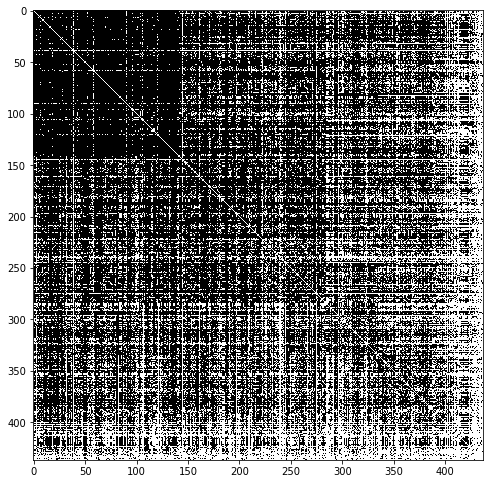

In [23]:

draw_adjacency_matrix(cpg)

### Observations


*   An edge between customers is represented by a dark point in the adjacency matrix plot
*   The adjacency matrix plot is square, representing the edge information between users

* The interconnected groups represent the cliques
* The adjacency matrix confirms that there is a lot shared purchase behavior in the frequent customer group. 



## Plot the Item Adjacency Matrix

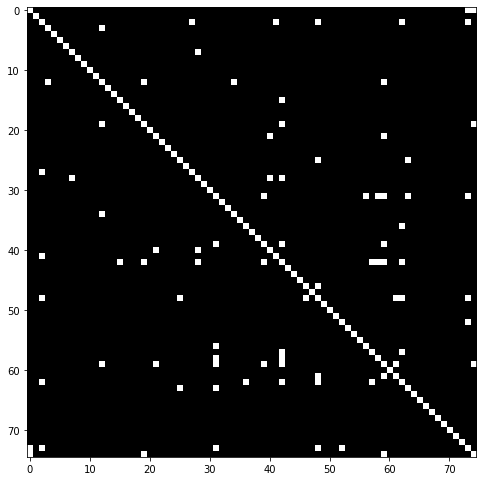

In [24]:
draw_adjacency_matrix(ipg)

### Observations


*   A review of the adjacency matrix of items shows that there is very strong co-purchasing behavior in the group of items. This group of items was determined by feature selection using the LASSO regression method. It turns out that the frequent customer group buys most of these groups of items. So this is a reflection of the feature selection process.
* The white spots represent items that are not purchased with an item. So in the item adjacency matrix, items that are not bought with an item are noteworthy observations.
*   The plot is a square. Each cell $(i,j)$ corresponds to an edge between node $i$ and node $j$. If there is an edge between $i$ and $j$, the cell is black, otherwise, it is white.
*   The adjacency matrix plots for both the customer projected graph and the item projected graph is shown.
*  A review of the matrix plots shows that a node is connected to many nodes in general.
* Cliques or networks where each node is connected to the other nodes in the group are common in both the item and customer projected graph.
* Cliques in the customer projected graph imply shared purchasing behavior. Cliques in the item projected graph indicate co-purchasing behavior




## Cluster with HDB Scan - Investigate Clustering Tendency

We can cluster the node embeddings to verify the properties of _small-world_ networks discussed in the overview section. The clustering is done with the _hdb scan_ algorithm. This algorithm can distinguish between points that belong to a cluster because they form a dense region versus points that are _noise_. Application of the clustering algorithm on both datasets resulted in the points being tagged as noise. In other words, we did not notice _hubs_ or groups nodes that are more well-connected to other nodes than others. These findings are consistent with what we expect in a _small world_ network. 

In [25]:
cna = np.zeros((cpg.number_of_nodes(), 32))
index = 0
for k,v in customer_emb.items():
  cna[index,:] = v
  index += 1

In [26]:
ina = np.zeros((ipg.number_of_nodes(), 32))
index = 0
for k,v in item_embedding.items():
  ina[index,:] = v
  index += 1

In [27]:
import hdbscan
clusterer = hdbscan.HDBSCAN(min_samples=5)
clusterer.fit(cna)

HDBSCAN(algorithm='best', allow_single_cluster=False, alpha=1.0,
        approx_min_span_tree=True, cluster_selection_epsilon=0.0,
        cluster_selection_method='eom', core_dist_n_jobs=4,
        gen_min_span_tree=False, leaf_size=40,
        match_reference_implementation=False, memory=Memory(location=None),
        metric='euclidean', min_cluster_size=5, min_samples=5, p=None,
        prediction_data=False)

In [28]:
np.unique(clusterer.labels_)

array([-1])

## Verify Lack of Clustering with Hopkins Test

We can apply a formal statistical test to illustrate that the embedded representation of the nodes does not exhibit clustering tendencies. This is done through the [Hopkins test](https://en.wikipedia.org/wiki/Hopkins_statistic). The test statistic will have values close to $1$ for data that show clustering and around $0.5$ for random data (noise). The value of the statistic for both the projection graphs is very different from $1$ and closer to the _noise_ range.

In [29]:
from pyclustertend import hopkins
hopkins(cna,cpg.number_of_nodes())

0.3246183655438504

In [30]:
hopkins(cna,ipg.number_of_nodes())

0.32129292599078846

## Identify Outliers with Isolation Forest

Since most nodes have a similar range of degrees, customers and abnormal items are interesting. We can identify these _novel_  customers and items with an _anomaly detection_ algorithm. In this work, the _Isolation Forest_ algorithm is used for anomaly detection. We need to specify the _contamination_ level, which indicates the _novelty_ we want to identify. The details of doing so are provided below. In this work, we do not _profile_ this group. If we wanted to identify _novel_ customers and items, we could apply an anomaly detection method for this purpose.

In [31]:
fp = "data/feature_selected_freq_shoppers.csv"
df = pd.read_csv(fp)
colsraw = df.columns.tolist()
cols_to_keep = [c for c in colsraw if c not in ['Customer_ID', 'RFM_score']]
df = df[cols_to_keep]

In [32]:
from sklearn.ensemble import IsolationForest

In [33]:
X = df.values

In [34]:
clf =IsolationForest(random_state=0, contamination=0.1).fit(X)


### Note
Points that are _novel_ are tagged with a $-1$ label, _regular_ points have a $1$ label

In [35]:
clf.predict(X)

array([ 1, -1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,
       -1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1, -1,  1,  1,  1, -1, -1,  1, -1,  1,  1, -1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1, -1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1, -1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1, -1, -1,  1,  1,  1, -1,  1,  1,  1,  1,
        1,  1,  1,  1, -1

## Log the Modeling Activity in Arangopipe

The last group of activities for this notebook is to store the results of this analysis in Arangopipe. The details are shown below.

In [36]:
ds_info = ap.lookup_dataset("Frequent_Customer_Graph")

In [37]:
fs_info = ap.lookup_featureset("Features are attributes of the nodes")

In [38]:
import io
import requests
url = ('https://raw.githubusercontent.com/rajivsam/interactive_tutorials/master/notebooks/Graph_Retail_DA_II.ipynb')
nbjson = requests.get(url).text

In [39]:

model_info = {"name": "DA_II_Analysis",  "task": "Exploratory Data Analysis", 'notebook': nbjson}
model_reg = ap.register_model(model_info, project = "Retail_Graph_Analytics")

In [40]:
import uuid
import datetime
#import jsonpickle

ruuid = str(uuid.uuid4().int)
model_perf = {'run_id': ruuid, "timestamp": str(datetime.datetime.now())}

#mp = jsonpickle.encode(mp)
model_params = {'run_id': ruuid, 'model_params': 'Not Applicable'}

run_info = {"dataset" : ds_info["_key"],\
                    "featureset": fs_info["_key"],\
                    "run_id": ruuid,\
                    "model": model_reg["_key"],\
                    "model-params": model_params,\
                    "model-perf": model_perf,\
                    "tag": "Retail Descriptive Analytics Part II",\
                    "project": "Retail_Graph_Analytics"}
ap.log_run(run_info)

## Summary


*   Exploration of the graph characteristics using node embeddings revealed that the observed characteristics were consistent with what is generally observed with _small world_ networks.
*  There is a high degree of shared taste (items purchased) in the _frequent customer group_
* There is a high level of co-purchasing behavior (items purchased together by a user) in the _frequent customer_ group.
* The above two properties imply many cliques in the _item_ and _customer_ projection graphs. Exploration done in this notebook confirms this.
* There are no _hubs_ in either the customer or item projection graphs.

